In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import random
import math
import pandas as pd

# Path to your Excel file
file_path = './UPDATED_NM student infractions 2010-2022.xlsx'

# Read the Excel file
df = pd.read_excel(file_path)

# Display the DataFrame
print(df)

                   District Name  District Code  \
0       ABQ SCHOOL OF EXCELLENCE            516   
1       ABQ SCHOOL OF EXCELLENCE            516   
2       ABQ SCHOOL OF EXCELLENCE            516   
3       ABQ SCHOOL OF EXCELLENCE            516   
4       ABQ SCHOOL OF EXCELLENCE            516   
...                          ...            ...   
285912                      ZUNI             89   
285913                      ZUNI             89   
285914                      ZUNI             89   
285915                      ZUNI             89   
285916                      ZUNI             89   

       Location Organization Type Code School Year Student Grade Level  \
0                              Charter  2014-06-30                   8   
1                              Charter  2014-06-30                   8   
2                              Charter  2014-06-30                   8   
3                              Charter  2014-06-30                   8   
4                

In [2]:
column_names = df.columns
print(column_names)
print(len(df))
group_lengths_list = df.groupby('District Name').size().tolist()
print(group_lengths_list)

Index(['District Name', 'District Code', 'Location Organization Type Code',
       'School Year', 'Student Grade Level', 'Infraction Event ID',
       'Discipline Infraction Date', 'Discipline Infraction Code',
       'Discipline Infraction', 'Drug Related', 'Alcohol Related',
       'Gang Related', 'Hate Crime', 'Serious Injury', 'Criminal Charge Code',
       'Repeat Offender', 'Discipline Response Code', 'Discipline Response',
       'Discipline Response Duration', 'Admin First Name', 'Admin Last Name',
       'Admin License Number', 'Student Gender Code',
       'Student Race Ethnicity Derived', 'Student Hispanic Indicator',
       'Special Ed Status Code', 'Gifted Participation Code', 'Immigrant',
       'Food Program Participation Code', 'Section 504 Status', 'R3', 'W1',
       'W2', 'W4', 'W5', 'WD', 'WDO', 'WG', 'WC'],
      dtype='object')
285917
[289, 9, 240, 48, 3751, 88971, 11, 3, 161, 60, 5, 133, 8, 10, 472, 4124, 4463, 2793, 1527, 294, 4621, 196, 5114, 177, 27, 183, 273, 

*PRIVACY MECHANISM*
Noising Entire Dataset (but assuming we are noising batches of data per year)
Varying Epsilon value per school, smaller school gets smaller epsilon (how? TODO)

In [7]:
def get_flip_probability(k, epsilon):
    """
    Compute flip probability based on K-ary Randomized Response equation.
    
    Calculates the probability to flip to a value based on the K-ary Randomized Response equation:
    PRflip = 1 - e^epsilon / (e^epsilon + k - 1)
    
    Args:
        k (int): Number of values (alphabets/categories) in the distribution (column).
        epsilon (float): The privacy budget.
    
    Returns:
        float: The probability to flip to a value.
    """
    PRflip = 1 - math.e**epsilon / (math.e**epsilon + k - 1)
    return PRflip

def flip_value(x, X, epsilon):
    """
    Randomly flips the value of 'x' using K-ary randomized response mechanism.
    
    Uses K-ary randomized response mechanism to randomly replace the value of 'x' with another value 'y' selected from 'X'.
    
    Args:
        x: The input value to potentially flip.
        X: A list of other possible values to choose from.
        epsilon: The privacy budget.
    
    Returns:
        y: The flipped or unchanged value of 'x'.
    """
    # Generate a random number between 0 and 1
    random_number = random.random()
    # Generate probability to flip x
    k = len(X) # number of values (alphabets/categories) in the domain
    flip_probability = get_flip_probability(k, epsilon)
    # Check if we should flip the value
    if random_number <= flip_probability:
        # Flip the value by selecting a random value from known_values other than 'x'
        y = random.choice([value for value in X if value != x])
        return y
    else:
        # Keep the value x
        return x

def noise_column(c_sr, X, epsilon):
    """
    Applies differential privacy to an entire column.
    
    Parameters:
        c_sr (pandas.Series): Pandas Series containing values from the column of interest.
        X (list): Possible values in the column.
        epsilon (float): Privacy budget for differential privacy. Lower values mean more privacy.
    
    Returns:
        list: List of privatized column values.
    """
    # Apply differential privacy to the list of c_sr
    c_private = map(lambda x: flip_value(x, X, epsilon), c_sr.tolist())
    c_private= list(c_private)
    return c_private

def get_epsilon(size, epsilon_config):
    """
    Get epsilon value depending on the number of entries in group/school.

    Parameters:
        size (int): Number of entries.
        epsilon_config (list): List of nested lists containing upper bound, lower bound, and corresponding epsilon value.

    Returns:
        float: Epsilon value.
    """
    default_epsilon = 1  # Default epsilon value
    epsilon = default_epsilon

    try:
        for config in epsilon_config:
            lower_bound, upper_bound, value = config
            if lower_bound <= size < upper_bound:
                epsilon = value
                print("Epsilon found: ", epsilon)
                break
            if upper_bound == -1 and size >= lower_bound:
                epsilon = value
                print("Epsilon found: ", epsilon)
                break
    except (TypeError, ValueError, IndexError):
        print("Warning: Epsilon configuration is poorly formatted. Default epsilon value will be used.")
        epsilon = default_epsilon

    return epsilon

def generate_possible_values(df, columns_to_noise):
    """
    Creates a dictionary of column names and lists of their respective values from the entire dataset.
    Only for columns that need to be noised.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing the school data.
        columns_to_noise (list): List of column headers that need to be noised.
    
    Returns:
        dict: Dictionary of column names and lists of their respective values.
    """
    possible_values = {}
    
    try:
        # Iterate over columns
        for column in columns_to_noise:
            # Get unique values for the column
            possible_values[column] = df[column].unique().tolist()
    except KeyError as e:
        print(f"Error: Column '{e}' not found in the DataFrame.")
    
    return possible_values


def noise_dataframe(df, columns_to_noise, epsilon_config):
    """
    Apply noising for entire dataset by noising every school district with adapted epsilon value. Columns are noised independently.
    
    Parameters:
        df (pandas.DataFrame): DataFrame containing the school data.
        columns_to_noise (list): List of column headers that need to be noised.
        epsilon_config (list): List of nested lists containing upper bound, lower bound, and corresponding epsilon value.
    
    Returns:
        pandas.DataFrame: DataFrame with noised values.
    """
    df_noised = pd.DataFrame(columns=df.columns)  # Empty placeholder
    
    # Generate possible values per column of interest
    values_per_column = generate_possible_values(df, columns_to_noise)
    
    # Get names of schools/school districts
    school_names = df['District Name'].unique().tolist()
    
    # Noising every school
    for school in school_names:
        print("*~*~*~*~* Running School:", school, "*~*~*~*~*")
        school_df = df[df['District Name'] == school].copy()
        
        # Get adaptive epsilon value
        school_case_numbers = len(school_df)
        curr_epsilon = get_epsilon(school_case_numbers, epsilon_config)
        
        for column in columns_to_noise:
            # Get unique values of column
            X = values_per_column[column]
            
            # Noise column
            noised_column = noise_column(school_df[column], X, curr_epsilon)
            school_df[column] = noised_column
        
        # Append noised school DataFrame to main noised DataFrame
        df_noised = pd.concat([df_noised, school_df], ignore_index=True)
    
    return df_noised

In [10]:
# TEST RUN NOISING
columns_to_noise = ["Discipline Infraction","Student Race Ethnicity Derived","Drug Related","Alcohol Related","Gang Related","Hate Crime","Serious Injury","Criminal Charge Code","Repeat Offender","Immigrant","Gifted Participation Code","Student Grade Level","Student Gender Code"
]
epsilon_config = [[0, 100, 3], [101, 1000, 4], [1001, -1, 5]] # does nothing for now
noised_df = noise_dataframe(df, columns_to_noise, epsilon_config)

*~*~*~*~* Running School: ABQ SCHOOL OF EXCELLENCE *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: ABQ SIGN LANGUAGE ACADEMY *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: ACADEMY OF TRADES AND TECH *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: ACE LEADERSHIP HIGH SCHOOL *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: ALAMOGORDO *~*~*~*~*
Epsilon found:  5


C:\Users\artem\AppData\Local\Temp\ipykernel_15684\3828553598.py:157: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_noised = pd.concat([df_noised, school_df], ignore_index=True)


*~*~*~*~* Running School: ALBUQUERQUE *~*~*~*~*
Epsilon found:  5
*~*~*~*~* Running School: ALBUQUERQUE BILINGUAL ACADEMY *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: ALBUQUERQUE COLLEGIATE CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: ALDO LEOPOLD CHARTER *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: ALMA D'ARTE CHARTER *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: ALTURA PREPARATORY SCHOOL *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: AMY BIEHL CHARTER HIGH SCHOOL *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: ANIMAS *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: ANTHONY CHARTER SCHOOL *~*~*~*~*
Epsilon found:  3
*~*~*~*~* Running School: ARTESIA *~*~*~*~*
Epsilon found:  4
*~*~*~*~* Running School: AZTEC *~*~*~*~*
Epsilon found:  5
*~*~*~*~* Running School: BELEN *~*~*~*~*
Epsilon found:  5
*~*~*~*~* Running School: BERNALILLO *~*~*~*~*
Epsilon found:  5
*~*~*~*~* Running School: BLOOMFIELD *~*~*~*~*
Epsilon found

======================RAW DF======================
REPEATED COUNTS===============================


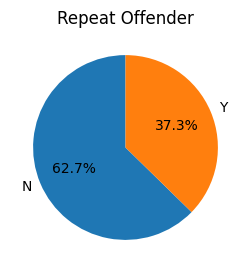

Grade COUNTS==================================
PK      862
KF     4749
1      6359
2      6732
3      7849
4      9322
5     11651
6     35301
7     44601
8     45976
9     46487
10    33491
11    20416
12    12111
OS       10
Name: count, dtype: int64
INFRACTIONS COUNTS==================================
Discipline Infraction
Disorderly Conduct                                                                     86323
Assault/battery with hands/feet/fist                                                   50429
Drug Violation                                                                         36125
Assault/battery simple                                                                 35213
Tobacco Use                                                                            13339
Other Violence - General                                                               11178
Bullying                                                                                7391
Missing Property/Thef

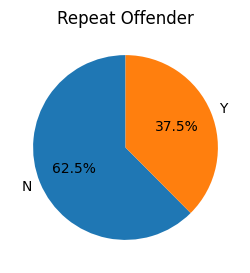

Grade COUNTS==================================
PK     2718
KF     6217
1      7619
2      8010
3      8997
4     10296
5     12365
6     33829
7     42120
8     43281
9     43521
10    31957
11    20167
12    12858
OS     1962
Name: count, dtype: int64
INFRACTIONS COUNTS==================================
Discipline Infraction
Disorderly Conduct                                                                     69541
Assault/battery with hands/feet/fist                                                   41447
Drug Violation                                                                         30020
Assault/battery simple                                                                 29105
Tobacco Use                                                                            12098
Other Violence - General                                                               10139
Bullying                                                                                7501
Missing Property/Thef

In [11]:
import matplotlib.pyplot as plt
def viz_testdf(df):
    # running some queries to quick hand test raw and noised df difference
    print("REPEATED COUNTS===============================")
    repeat_counts = df['Repeat Offender'].value_counts()
    repeat_counts.plot(kind='pie', figsize=(3, 3), autopct='%1.1f%%', startangle=90)
    plt.title('Repeat Offender')
    plt.ylabel('')  # Hide the y-label
    plt.show()
    print("Grade COUNTS==================================")
    # Assuming df['Student Grade Level'] contains the grade levels as shown previously
    grade_counts = df['Student Grade Level'].value_counts()
    # Define the correct order for the grade levels
    grade_order = ['PK', 'KF', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'OS']
    # Convert the grade levels in the index to a Categorical type with the defined order
    grade_counts.index = pd.Categorical(grade_counts.index, categories=grade_order, ordered=True)
    # Sort the Series by its index
    sorted_grade_counts = grade_counts.sort_index()
    print(sorted_grade_counts)
    print("INFRACTIONS COUNTS==================================")
    Discipline_Infraction_counts = df['Discipline Infraction'].value_counts()
    print(Discipline_Infraction_counts)

print("======================RAW DF======================")
viz_testdf(df)
print("======================NOISED DF======================")
viz_testdf(noised_df)